In [5]:
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler
import skimage.segmentation as seg

import numpy as np

import nglpy_cuda as ngl
import topopy
import pdir
import time
import os
import utpy.utils
import utpy.vis
import flatpy
from functools import partial
from itertools import cycle

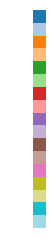

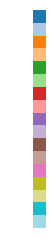

In [6]:
palettes = [[[141, 211, 199], [255, 255, 179], [190, 186, 218],
           [251, 128, 114], [128, 177, 211], [253, 180, 98],
           [179, 222, 105], [252, 205, 229], [217, 217, 217]],
          [[228,26,28], [55,126,184], [77,175,74],
           [152,78,163],[255,127,0],[255,255,51],
           [166,86,40],[247,129,191],[153,153,153]],
          [[105,239,123], [149,56,144], [66,30,200],
           [14,80,62], [153,222,249], [24,81,155],
           [218,185,255], [192,222,164], [183,211,33]],
          [[251,180,174],[179,205,227],[204,235,197],
           [222,203,228],[254,217,166],[255,255,204],
           [229,216,189],[253,218,236],[242,242,242]],
          np.array(np.array(plt.cm.tab10.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20b.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20c.colors)*255, dtype=int),
          [[27,158,119], [217,95,2], [117,112,179],
           [231,41,138], [102,166,30], [230,171,2],
           [166,118,29], [102,102,102]],
          [np.array(np.array(plt.cm.viridis(i/3))*255, dtype=int) for i in range(4)]
         ]

ideal_map = np.array(np.array(plt.cm.tab20.colors)*255, dtype=int)
ideal_map = np.delete(ideal_map, 15, axis=0)
ideal_map = np.delete(ideal_map, 14, axis=0)
ideal_map = np.delete(ideal_map, 13, axis=0)
palettes = [ideal_map]
color_list = ideal_map
plt.figure()
X = []
for i in range(len(color_list)):
    for row in range(10):
        x =[]
        for col in range(10):
            x.append(color_list[i])
        X.append(x)
plt.imshow(X)
plt.gca().axis("off")

for color_list in palettes:
    plt.figure()
    X = []
    for i in range(len(color_list)):
        for row in range(10):
            x =[]
            for col in range(10):
                x.append(color_list[i])
            X.append(x)
    plt.imshow(X)
    plt.gca().axis("off")



In [7]:
foo = flatpy.nD.available_functions["ackley"]
fractional_noise_level=0.6
persistence = 0.665
n_clusters = 9
count = 50
noise_level = 0.5*persistence*fractional_noise_level
noise_model = "nonparametric"
ground_truth, ensemble = utpy.utils.generate_ensemble(foo, noise_level, count, noise_model)
ensemble = -ensemble
ground_truth = -ground_truth

graph_params = {
    "index": None, "max_neighbors": 10, "relaxed": False, "beta": 1, "p": 2.
}
maxima_map = utpy.utils.create_assignment_map(ensemble, n_clusters=n_clusters, persistence=persistence)

/home/maljovec/miniconda3/envs/gpu/lib/python3.6/site-packages/scikit_learn-0.20.0-py3.6-linux-x86_64.egg/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
mean_realization = np.mean(ensemble, axis=2)
median_realization = np.median(ensemble, axis=2)

In [9]:
def show_msc(grid, persistence=None, n_clusters=None, color="#000000"):
    X, Y = utpy.utils.massage_data(grid)
    h, w = grid.shape

    graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
    tmc = topopy.MorseComplex(graph=graph,
                              gradient='steepest',
                              normalization=None)
    tmc.build(X, Y)

    if persistence is None:
        for p in tmc.persistences:
            if len(tmc.get_partitions(p).keys()) <= n_clusters:
                persistence = p
                break

    partitions = tmc.get_partitions(persistence)
    keys = partitions.keys()

    keyMap = {}
    levels = []
    for i, k in enumerate(keys):
        keyMap[k] = i
        levels.append(i+0.5)

    color_mesh = np.zeros((h, w))
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // w, idx % w] = keyMap[key]

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    for i in keyMap.values():
        lines = plt.contour(color_mesh == i, colors=color, levels=levels, linewidths=1)
    plt.gca().set_aspect("equal")
    return lines

In [10]:
def show_contour_overlay(ensemble, assignments):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(*[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[0.99999, 1], colors=my_color, alpha=0.5)
#         if colored:
#             plt.contourf(colored_images[i][:, :, 3], levels=[
#                          1e-6, 1], colors=my_color, alpha=0.5)
#         else:
#             plt.contourf(colored_images[i][:, :, 3], levels=[
#                          0.99999, 1], colors=my_color, alpha=0.5)
        plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                    1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

In [11]:
persistence = utpy.utils.get_persistence_from_count(ensemble, n_clusters)
assignments = partial(utpy.utils.assign_labels, maxima_map=maxima_map, n_clusters=n_clusters, persistence=persistence)

In [12]:
def show_combined_overlay(ensemble, assignments, ccycle, gamma=2.2, color="#000000", certainty=1):
    eps = 1e-6
    fig, ax = plt.subplots(4, 1, figsize=(5, 20), dpi=100)
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    certain_mask = np.zeros(label_images[0].shape, dtype=bool)
    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count
        certain_mask = np.logical_or(certain_mask, label_image / count >= certainty-eps)

    composite_image = 255*np.ones(colored_images[0].shape)[:, :, :-1]
    for colored_image in colored_images:
        composite_image = utpy.vis.overlay_alpha_image_precise(
            composite_image, 255*colored_image, 1., gamma)
    for i, triplet in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(*[hex(c).split('x')[-1] for c in triplet])
        ax[2].contourf(colored_images[i][:, :, 3], levels=[
                     certainty-eps, 1], colors="#FFFFFF", alpha=1)
        ax[3].contourf(colored_images[i][:, :, 3], levels=[
                     certainty-eps, 1], colors="#FFFFFF", alpha=1)
#         ax[1].contourf(colored_images[i][:, :, 3], levels=[0.99999, 1], colors=my_color, alpha=1)
        ax[2].contour(colored_images[i][:, :, 3], levels=[0.5], colors="#000000", linewidths=[0.5], linestyles=['solid'])
        ax[3].contour(colored_images[i][:, :, 3], levels=[0.5], colors="#000000", linewidths=[0.5], linestyles=['solid'])

    certain_image = np.copy(composite_image)
    certain_image[~np.dstack((certain_mask,)*3)] = 255
    ax[0].imshow(certain_image)
    ax[1].imshow(composite_image)
    ax[2].imshow(composite_image)
    ax[3].imshow(composite_image)
    for a in ax:
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        # a.set_ylim(ensemble.shape[0], 0)
        a.set_ylim(0, ensemble.shape[0])

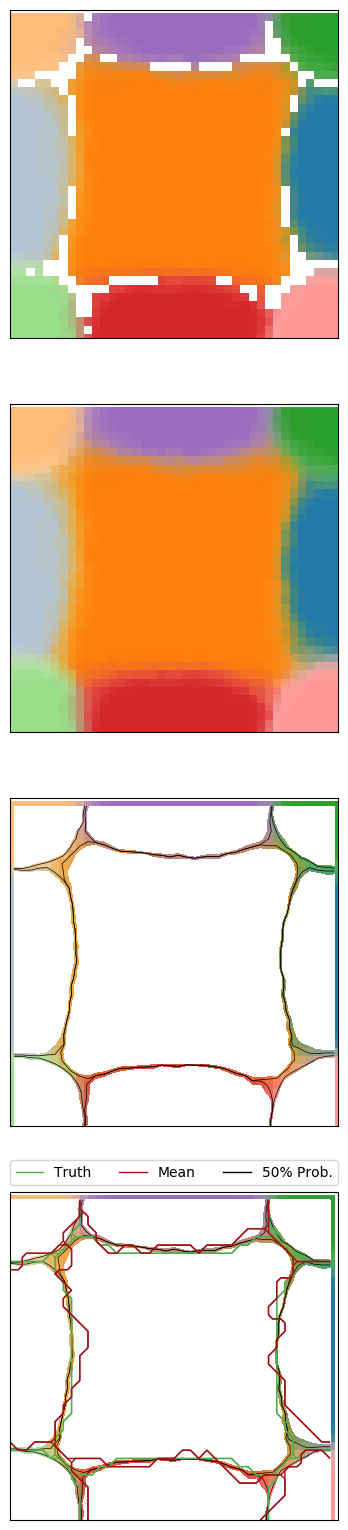

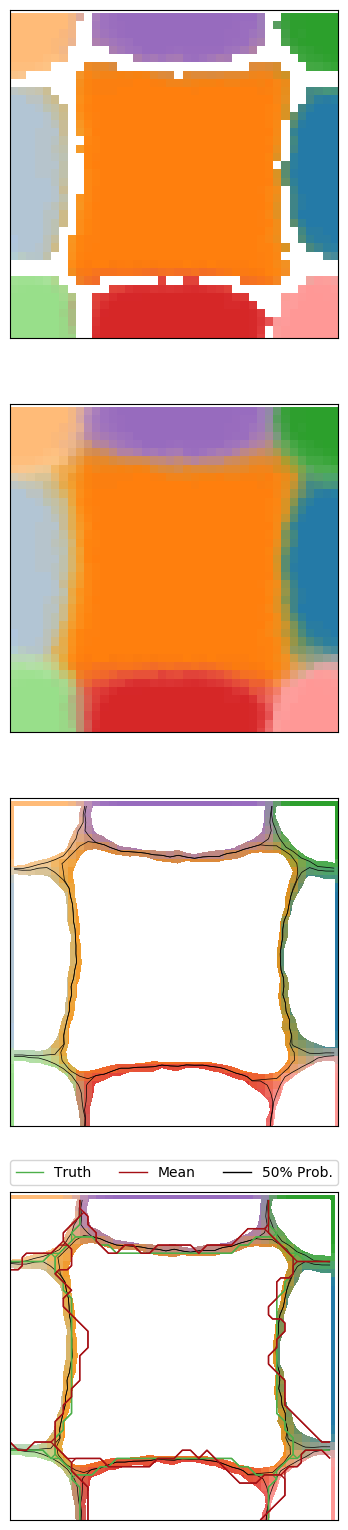

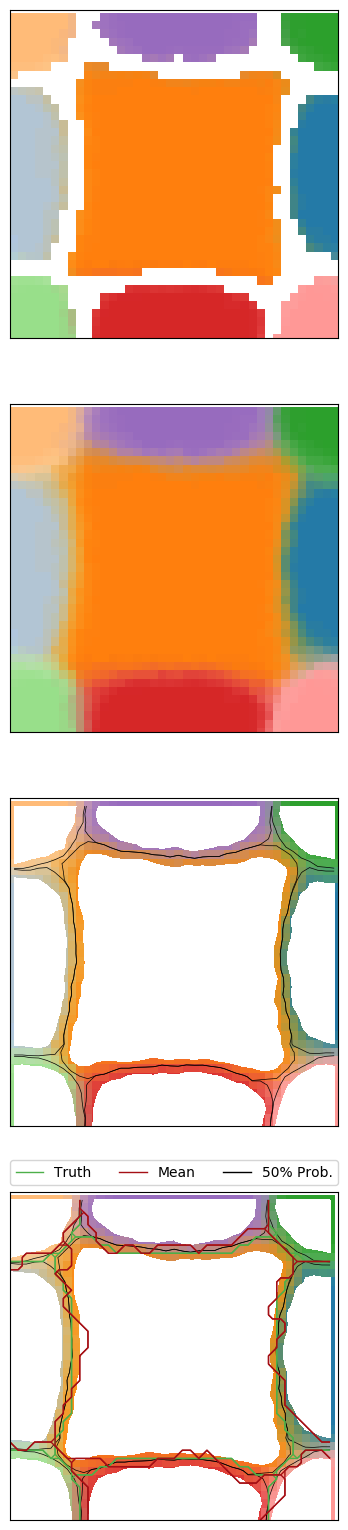

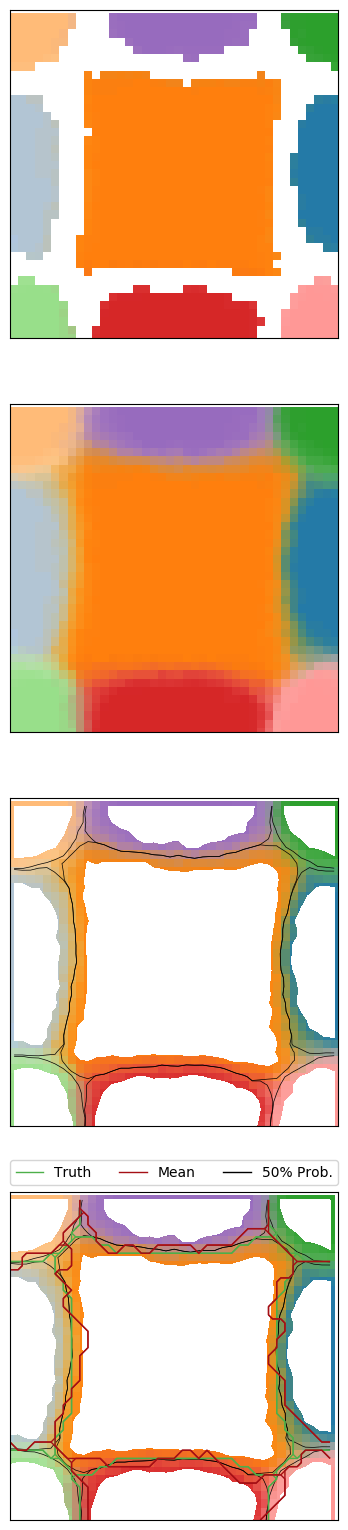

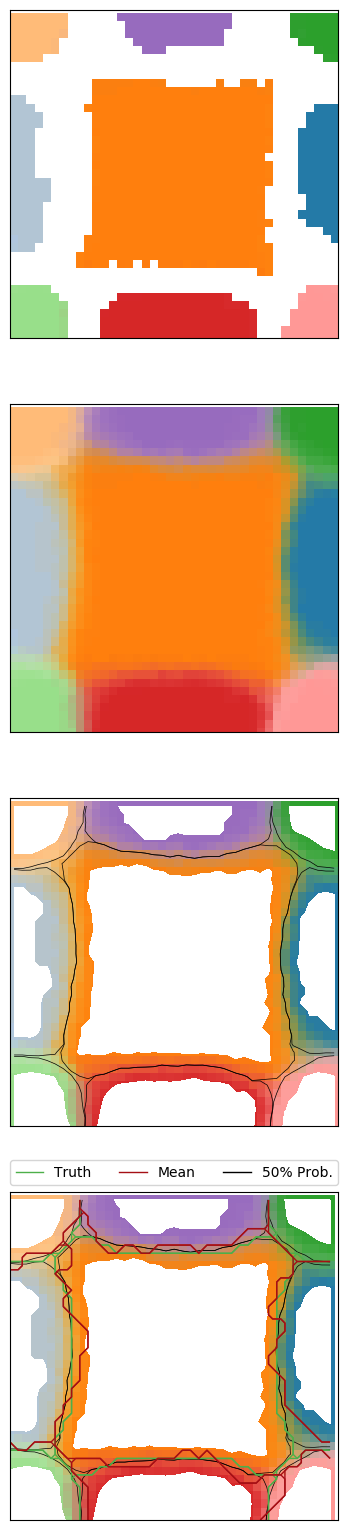

In [13]:
for i,color_list in enumerate(palettes):
    for certainty in [0.6, 0.7, 0.8, 0.9, 0.95]:
        ccycle = cycle(color_list)

        umc_color = "#000000"
        gt_color = "#4daf4a"
        mean_color = "#a50f15"
        show_combined_overlay(ensemble, assignments, ccycle, 0.2, umc_color, certainty)
        show_msc(ground_truth, n_clusters=n_clusters, color=gt_color)
        show_msc(mean_realization, n_clusters=n_clusters, color=mean_color)
        plt.plot([-1,-0.5], [0,1], color=gt_color, linewidth=1, label="Truth")
        plt.gca().plot([-1,-0.5], [0,1], color=mean_color, linewidth=1, label="Mean")
        plt.gca().plot([-1,-0.5], [0,1], color=umc_color, linewidth=1, label="50% Prob.")
        plt.gca().set_xlim(0, ensemble.shape[1])
        plt.gca().set_ylim(0,ensemble.shape[0])
        _ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
        plt.savefig("ackley_{}_{}.png".format(noise_model, certainty))

In [14]:
def show_certain_regions(ensemble, assignments, contours=False):
    ps = []
    fields = []
    count = ensemble.shape[2]
    for i in range(count):
        field, p = assignments(ensemble[:, :, i])
        ps.append(p)
        fields.append(field)

    ps = np.array(ps)
    fields = np.array(fields)

    num_partitions = len(np.unique(fields[0]))
    shape = (num_partitions,) + fields[0].shape
    label_images = np.zeros(shape)

    for i in range(num_partitions):
        test_image = (fields == i)
        label_images[i] = np.sum(test_image, axis=0)

    colored_images = []
    for i, c in zip(range(num_partitions), ccycle):
        colored_image = np.zeros(label_images[0].shape + (4,))
        colored_image[:, :, 0] = c[0]/255.
        colored_image[:, :, 1] = c[1]/255.
        colored_image[:, :, 2] = c[2]/255.
        colored_images.append(colored_image)

    for i, label_image in enumerate(label_images):
        colored_images[i][:, :, 3] = label_image / count

    for i, color in zip(range(num_partitions), ccycle):
        my_color = "#{:>02}{:>02}{:>02}".format(
            *[hex(c).split('x')[-1] for c in color])
        plt.contourf(colored_images[i][:, :, 3], levels=[
                     0.99999, 1], colors=my_color, alpha=1)
        if contours:
            plt.contour(colored_images[i][:, :, 3], levels=[0.0, 0.5, 1], colors=my_color, linewidths=[
                        1, 0.5, 1.0], linestyles=['solid', 'dashed', 'solid'])
        # else:
        #     plt.contour(colored_images[i][:, :, 3], levels=[0.0, 1], colors=my_color, linewidths=[
        #                 1, 1.0], linestyles=['solid', 'dashed', 'solid'])
    plt.gca().set_xlim(0, ensemble.shape[1])
    # plt.gca().set_ylim(ensemble.shape[0], 0)
    plt.gca().set_ylim(0, ensemble.shape[0])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().set_aspect('equal')

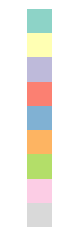

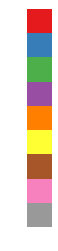

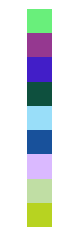

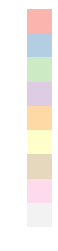

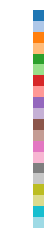

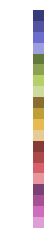

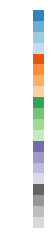

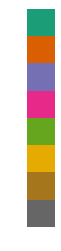

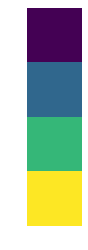

In [15]:
colors = [[[141, 211, 199], [255, 255, 179], [190, 186, 218],
           [251, 128, 114], [128, 177, 211], [253, 180, 98],
           [179, 222, 105], [252, 205, 229], [217, 217, 217]],
          [[228,26,28], [55,126,184], [77,175,74],
           [152,78,163],[255,127,0],[255,255,51],
           [166,86,40],[247,129,191],[153,153,153]],
          [[105,239,123], [149,56,144], [66,30,200],
           [14,80,62], [153,222,249], [24,81,155],
           [218,185,255], [192,222,164], [183,211,33]],
          [[251,180,174],[179,205,227],[204,235,197],
           [222,203,228],[254,217,166],[255,255,204],
           [229,216,189],[253,218,236],[242,242,242]],
          np.array(np.array(plt.cm.tab20.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20b.colors)*255, dtype=int),
          np.array(np.array(plt.cm.tab20c.colors)*255, dtype=int),
            [[27,158,119], [217,95,2], [117,112,179],
            [231,41,138], [102,166,30], [230,171,2],
            [166,118,29], [102,102,102]],
           [np.array(np.array(plt.cm.viridis(i/3))*255, dtype=int) for i in range(4)]
         ]

for color_list in colors:
    plt.figure()
    X = []
    for i in range(len(color_list)):
        for row in range(10):
            x =[]
            for col in range(10):
                x.append(color_list[i])
            X.append(x)
    plt.imshow(X)
    plt.gca().axis("off")



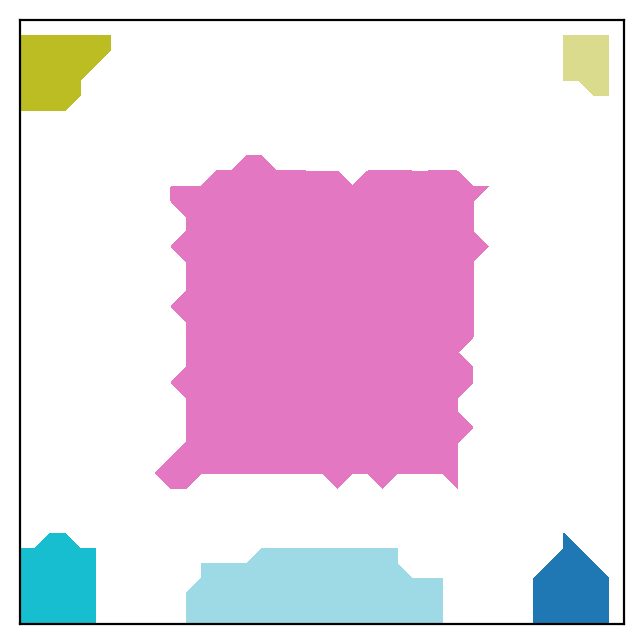

In [16]:
plt.figure(dpi=200)
show_certain_regions(ensemble, assignments)

TypeError: zip argument #2 must support iteration

<Figure size 1200x800 with 0 Axes>

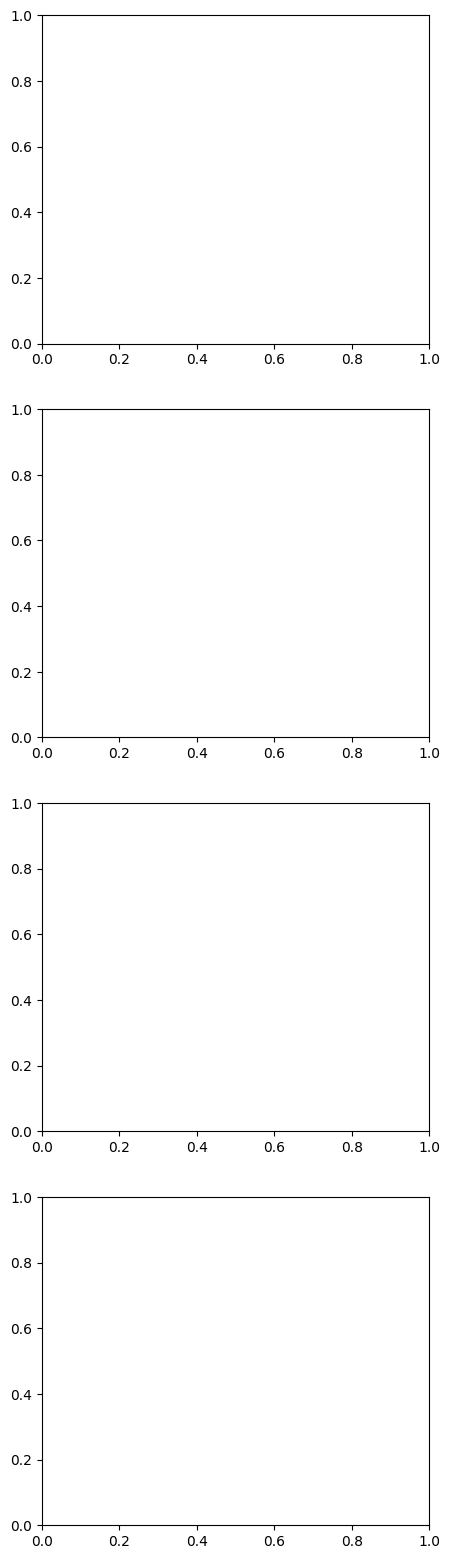

In [17]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.6, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

In [ ]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 0.8, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

In [ ]:
plt.figure(dpi=200)
show_combined_overlay(ensemble, assignments, 2.2, False)
# show_msc(ground_truth, n_clusters=n_clusters, color="#4daf4a")
# show_msc(mean_realization, n_clusters=n_clusters, color="#e41a1c")
plt.plot([-1,-0.5], [0,1], color="#4daf4a", linewidth=1, label="ground truth")
plt.plot([-1,-0.5], [0,1], color="#e41a1c", linewidth=1, label="mean")
plt.gca().set_xlim(0,39)
plt.gca().set_ylim(0,39)
_ = plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

# Flow Analysis

# Persistence Example

In [1]:
import flatpy
from ipywidgets import interact, widgets

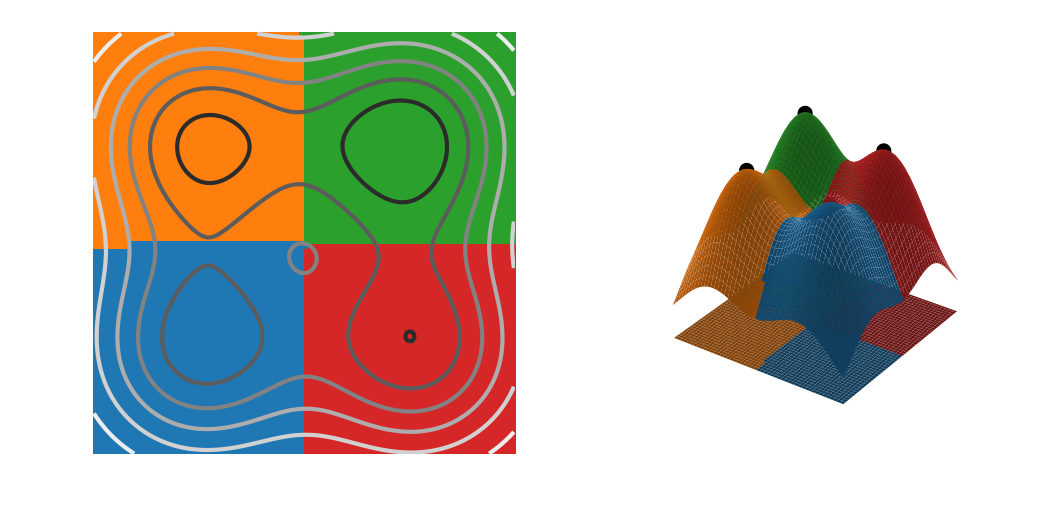

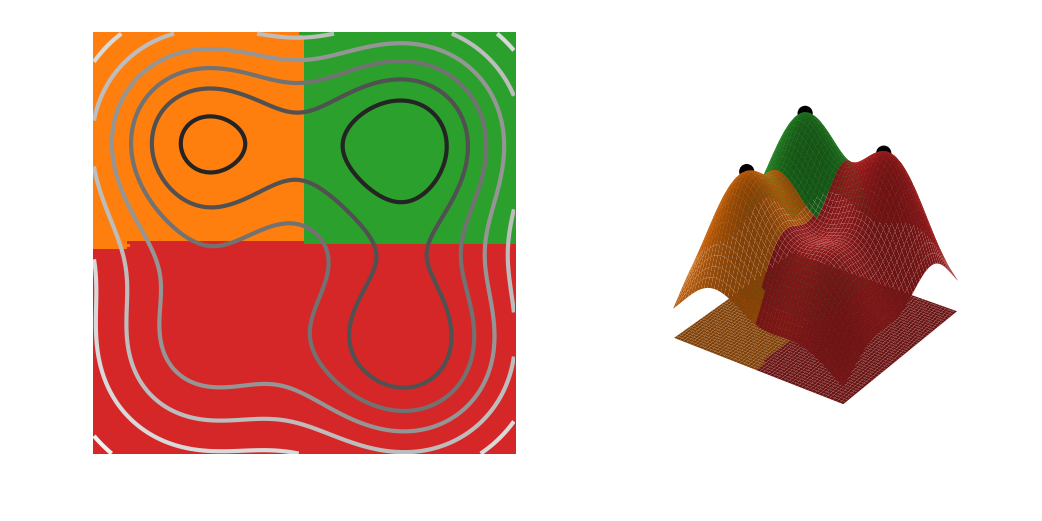

In [4]:
%matplotlib inline

sigma = 0.075
max_x_1 = 0.25
max_y_1 = 0.25
max_x_2 = 0.25
max_y_2 = 0.75
def four_bumps(_x):
    x, y = flatpy.utils.unpack_2d(_x)
    eps = 0.01*y + 0.01*x
    return (0.5 * np.exp(-(((x-max_x_1)**2)/sigma +((y-max_y_1)**2)/sigma)) +
            0.54 * np.exp(-(((x-0.75)**2)/sigma +((y-0.25)**2)/sigma)) +
            0.51 * np.exp(-(((x-max_x_2)**2)/sigma +((y-0.77)**2)/sigma)) +
            0.58 * np.exp(-(((x-0.75)**2)/sigma +((y-0.75)**2)/sigma)) + eps
           )

def three_bumps(_x, t=0.4):
    x, y = flatpy.utils.unpack_2d(_x)
    eps = 0.01*y + 0.01*x
    amplitude = (1-t)*0.54
    x_loc = (1-t)*max_x_1 + t*max_x_2
    return (amplitude * np.exp(-(((x-x_loc)**2)/sigma +((y-max_y_1)**2)/sigma)) +
            0.54 * np.exp(-(((x-0.75)**2)/sigma +((y-0.25)**2)/sigma)) +
            0.51 * np.exp(-(((x-max_x_2)**2)/sigma +((y-max_y_2)**2)/sigma)) +
            0.58 * np.exp(-(((x-0.75)**2)/sigma +((y-0.75)**2)/sigma)) + eps
           )

resolution=150
X = flatpy.utils.generate_test_grid_2d(resolution)
f1 = four_bumps(X)
f2 = three_bumps(X)

x, y = np.mgrid[0:1:(resolution *1j), 0:1:(resolution*1j)]
f1 = f1.reshape(resolution,resolution)
f2 = f2.reshape(resolution,resolution)

graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
tmc = topopy.MorseComplex(graph=graph, normalization=None)
tmc.build(X, f1.flatten())

n_clusters = 4
for p in tmc.persistences:
    if len(tmc.get_partitions(p).keys()) <= n_clusters:
        partitions = tmc.get_partitions(p)
        break

keys = list(partitions.keys())
keyMap = {}
for i, k in enumerate(keys):
    keyMap[k] = i

ccycle = cycle(plt.cm.tab10.colors)
uniqueCount = len(keys)
usedColors = []
for i, c in zip(range(uniqueCount), ccycle):
    usedColors.append(c)
cmap = colors.ListedColormap(usedColors)

for f in [f1, f2]:
    for p in tmc.persistences:
        if len(tmc.get_partitions(p).keys()) <= n_clusters:
            partitions = tmc.get_partitions(p)
            break

    color_mesh = np.zeros((resolution, resolution), dtype=int)
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // resolution, idx % resolution] = keyMap[key]
    
    keys = list(partitions.keys())
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(plt.cm.tab10(color_mesh.T))
    ax.set_ylim(0,resolution)
#     ax.set_xlim(resolution,0)
    ax.axis("off")
    plt.contour(f,cmap=plt.cm.Greys)
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    surf = ax.plot_surface(x, y, f, linewidth=0, antialiased=True, facecolors=plt.cm.tab10(color_mesh))
    surf = ax.plot_surface(x, y, np.zeros(x.shape), linewidth=0, antialiased=True, facecolors=plt.cm.tab10(color_mesh))
    ax.scatter(X[keys, 0], X[keys, 1], f.flatten()[keys], s=20, alpha=1, c="#000000",zorder=5)
    # ax.contour(x, y, f, cmap=plt.cm.Greys, linewidths=3, alpha=1)
    ax.view_init(azim=215)
    ax.set_aspect(1)
    ax.axis("off")
    n_clusters -= 1